<a href="https://colab.research.google.com/github/sofit-c23-ps233/SoFit-MachineLearning/blob/main/model_ml/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("tmp/500_Person_Gender_Height_Weight_Index.csv")

In [ ]:
df.head()

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


In [ ]:
# The gender is stil in "object" datatypes, let's convert it to an integer

df["Gender"] = df["Gender"].replace({'Male': 1, 'Female': 0})

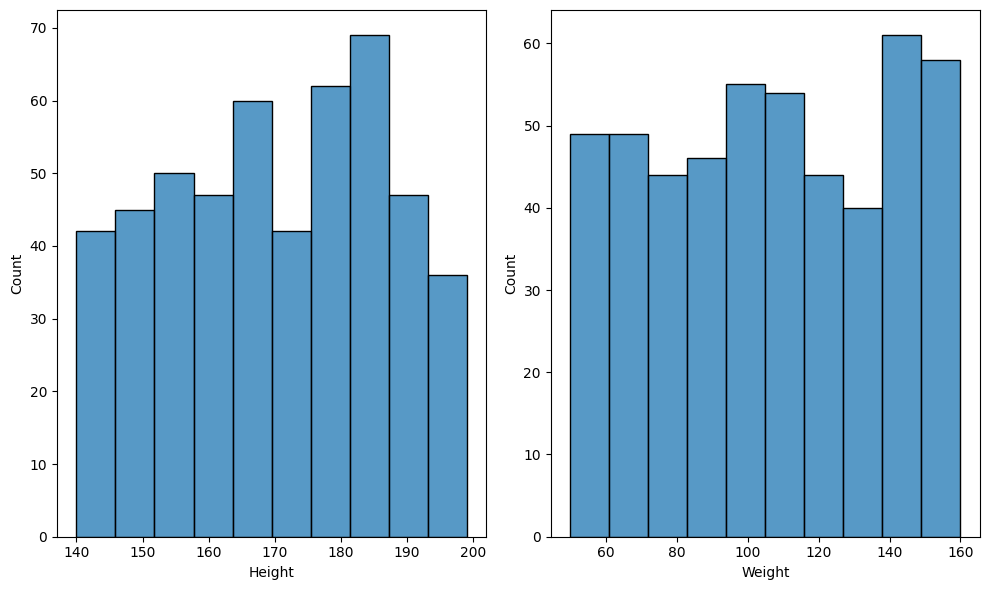

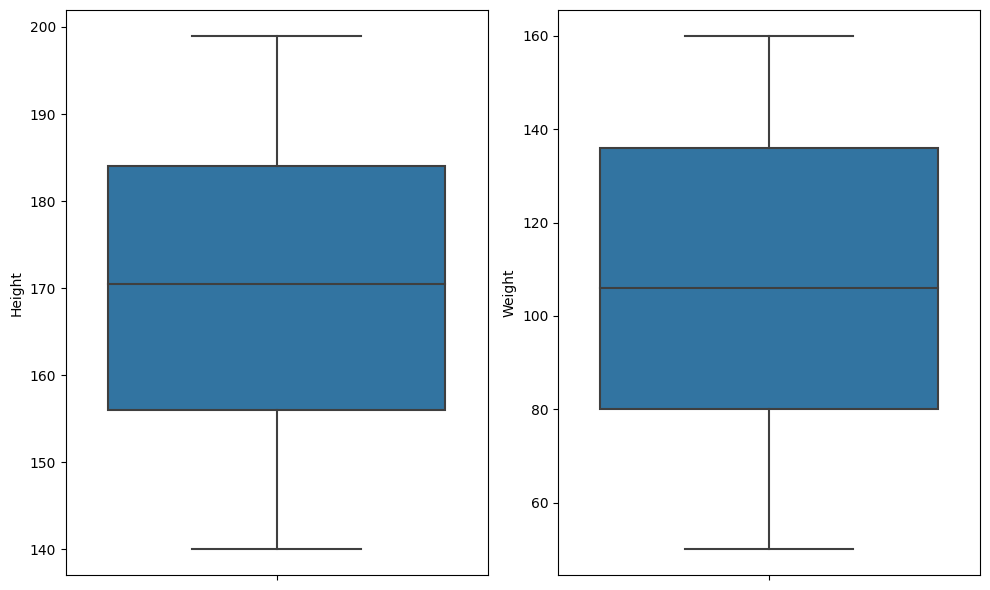

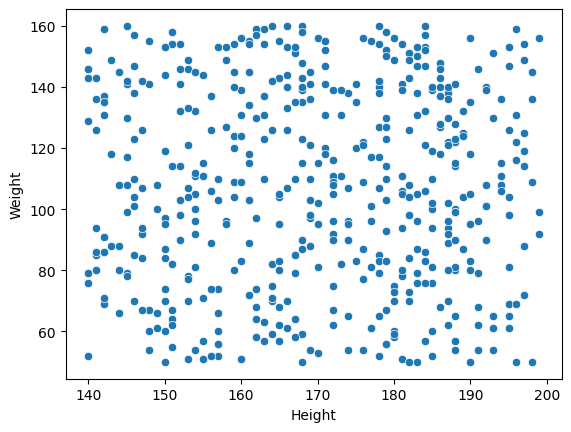

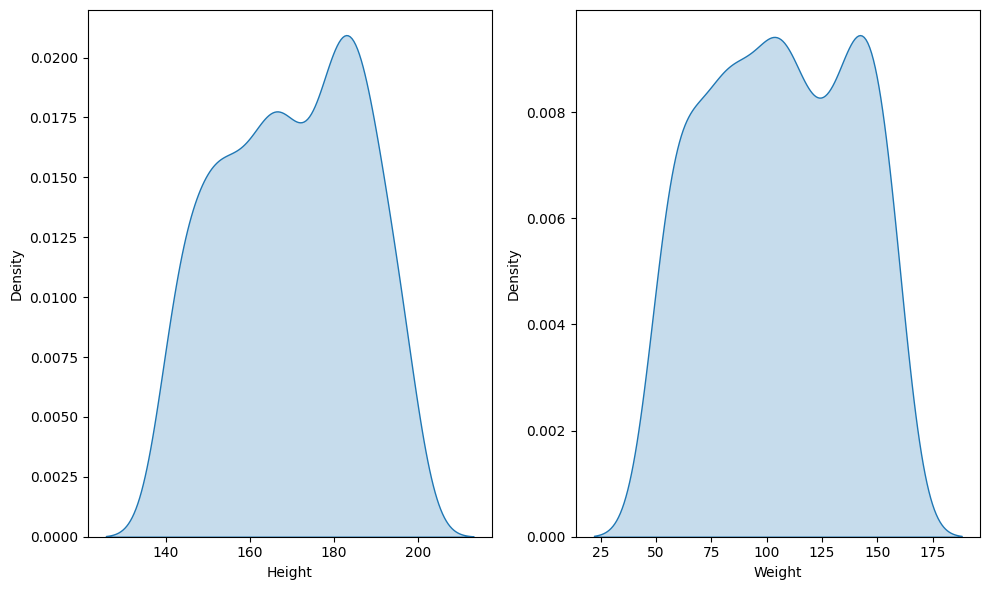

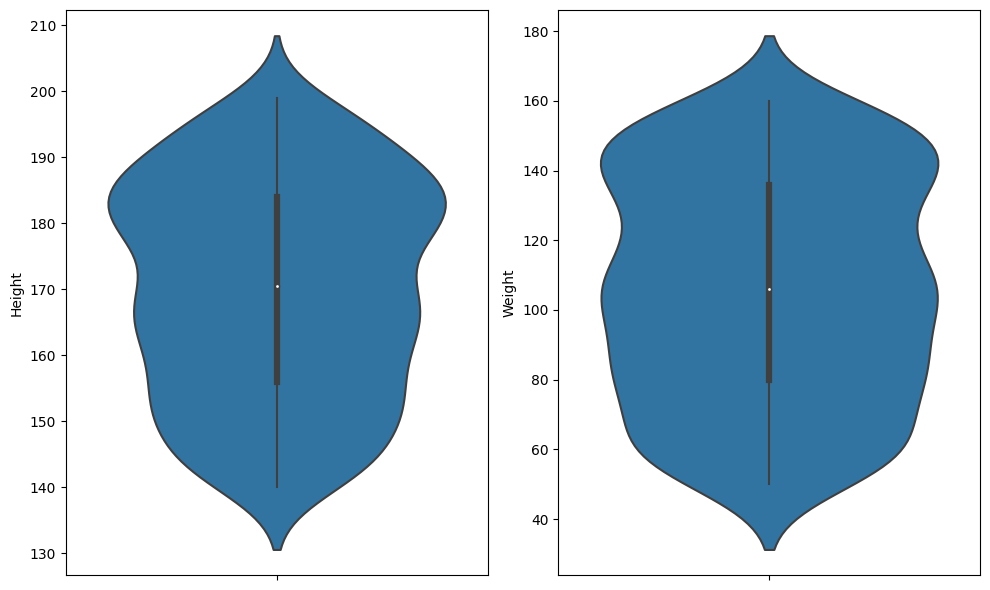

In [ ]:
# Visualize the distribution first to check

# Histogram
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Height')
plt.xlabel('Height')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='Weight')
plt.xlabel('Weight')

plt.tight_layout()
plt.show()

# Box plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, y='Height')
plt.ylabel('Height')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='Weight')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()

# Scatter plot
sns.scatterplot(data=df, x='Height', y='Weight')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

# Kernel Density Plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(data=df, x='Height', fill=True)  # Use fill parameter
plt.xlabel('Height')

plt.subplot(1, 2, 2)
sns.kdeplot(data=df, x='Weight', fill=True)  # Use fill parameter
plt.xlabel('Weight')

plt.tight_layout()
plt.show()

# Violin plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.violinplot(data=df, y='Height')
plt.ylabel('Height')

plt.subplot(1, 2, 2)
sns.violinplot(data=df, y='Weight')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()


As we can see, the data is not normally distributed, So I guess we will use the z-score normalization method

In [ ]:
# Let's "normalize" this dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[["Height_normalized", "Weight_normalized"]] = scaler.fit_transform(df[["Height", "Weight"]])


In [ ]:
# Drop the Height and Weight
df.drop(columns=["Height", "Weight"], inplace=True)

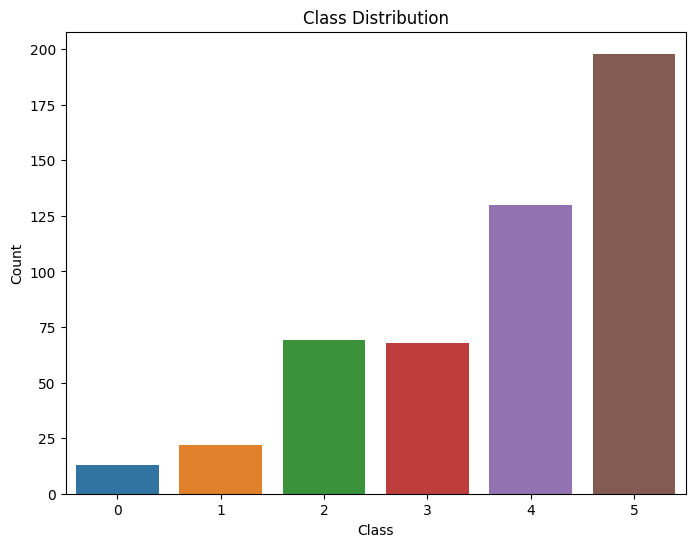

In [ ]:
# Before doing the modelling, check whether the data is balanced or not

# Count the occurrences of each class
class_counts = df['Index'].value_counts()

# Bar plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Index')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
df.columns

Index(['Gender', 'Index', 'Height_normalized', 'Weight_normalized'], dtype='object')

In [ ]:
# This dataset is highly unbalanced, Let's try to balanced it using SMOTE

from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate the features and the target
X = df.drop(columns=["Index"]) # Features
y = df["Index"]

# Apply SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Index'])], axis=1)

# Check the class distribution after applying SMOTE
print(df_resampled['Index'].value_counts())

4    198
2    198
3    198
5    198
1    198
0    198
Name: Index, dtype: int64


In [ ]:
# Okay, now we have the balanced dataset in df_resampled

df_resampled.head()

,Gender,Height_normalized,Weight_normalized,Index
0,1,0.247939,-0.309117,4
1,1,1.164872,-0.587322,2
2,0,0.920357,0.123647,4
3,0,1.531645,-0.061823,3
4,1,-1.280283,-1.391027,3


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models

# Create a DataFrame with the given data
df = df_resampled

# Preprocessing
X = df[['Gender', 'Height_normalized', 'Weight_normalized']]  # Features
y = df['Index']  # Target variable

# Encode categorical variables
label_encoder = LabelEncoder()
X.loc[:, 'Gender'] = label_encoder.fit_transform(X['Gender'])  # Using .loc to modify the DataFrame

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network architecture
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(3,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))  # Increase the number of neurons
model.add(layers.Dense(6, activation='softmax'))  # We have 6 classes in 'Index'

# Compile the model with a different optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with more epochs and smaller batch size
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

Epoch 1/200


<ipython-input-38-a809a555d0a2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Gender'] = label_encoder.fit_transform(X['Gender'])  # Using .loc to modify the DataFrame


60/60 [==============================] - 1s 6ms/step - loss: 1.5125 - accuracy: 0.3926 - val_loss: 1.1776 - val_accuracy: 0.5336
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.9349 - accuracy: 0.6316 - val_loss: 0.7795 - val_accuracy: 0.6891
Epoch 3/200
60/60 [==============================] - 0s 4ms/step - loss: 0.6536 - accuracy: 0.7484 - val_loss: 0.6015 - val_accuracy: 0.7983
Epoch 4/200
60/60 [==============================] - 0s 4ms/step - loss: 0.5101 - accuracy: 0.8305 - val_loss: 0.5182 - val_accuracy: 0.8067
Epoch 5/200
60/60 [==============================] - 0s 4ms/step - loss: 0.4230 - accuracy: 0.8495 - val_loss: 0.4450 - val_accuracy: 0.7815
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.3563 - accuracy: 0.8926 - val_loss: 0.3742 - val_accuracy: 0.8866
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.3249 - accuracy: 0.9095 - val_loss: 0.3199 - val_accuracy: 0.9328
Epoch 8/200
60/60 [======

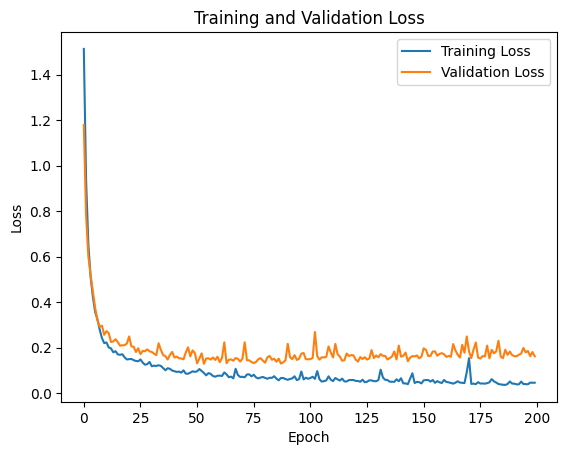

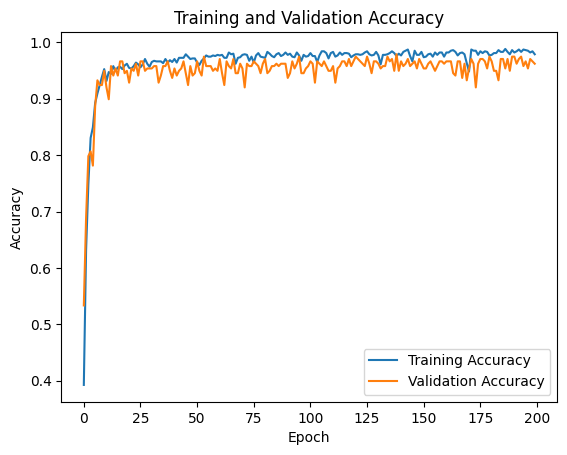

In [ ]:
# Plot the training and validation curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Get the predicted index for a new data point
import numpy as np
new_data = np.array([[1, 180, 58]])
predicted_index = np.argmax(model.predict(new_data))
print('Predicted Index:', predicted_index)

1/1 [==============================] - 0s 82ms/step
Predicted Index: 2


In [ ]:
model.save('tmp/model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Succ

In [ ]:
import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(model, 'tmp/tfjs_data')